### Import required libaries

In [9]:
%pip install -qqq transformers==4.27.2 --progress-bar off
%pip install -qqq pytorch-lightning==1.9.4 --progress-bar off
%pip install -qqq torchmetrics==0.11.4 --progress-bar off
%pip install -qqq imgkit==1.2.3 --progress-bar off
%pip install -qqq easyocr==1.6.2 --progress-bar off
%pip install -qqq Pillow==9.4.0 --progress-bar off
%pip install -qqq tensorboardX==2.5.1 --progress-bar off
%pip install -qqq huggingface_hub==0.11.1 --progress-bar off
%pip install -qqq --upgrade --no-cache-dir gdown

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow as tf
from transformers import LayoutLMv3FeatureExtractor, LayoutLMv3TokenizerFast, LayoutLMv3Processor, LayoutLMv3ForSequenceClassification
from tqdm import tqdm
import torch
import pickle
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from PIL import Image, ImageDraw, ImageFont
import numpy as np
from sklearn.model_selection import train_test_split
import imgkit
import random
import easyocr
import torchvision.transforms as T
from pathlib import Path
import matplotlib.pyplot as plt
import os
import cv2
from typing import List
import json
from torchmetrics import Accuracy
import huggingface_hub
from huggingface_hub import notebook_login
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
 
%matplotlib inline
pl.seed_everything(42)

2023-08-25 13:27:09.416198: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-25 13:27:09.449443: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-25 13:27:10.067330: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Global seed set to 42


42

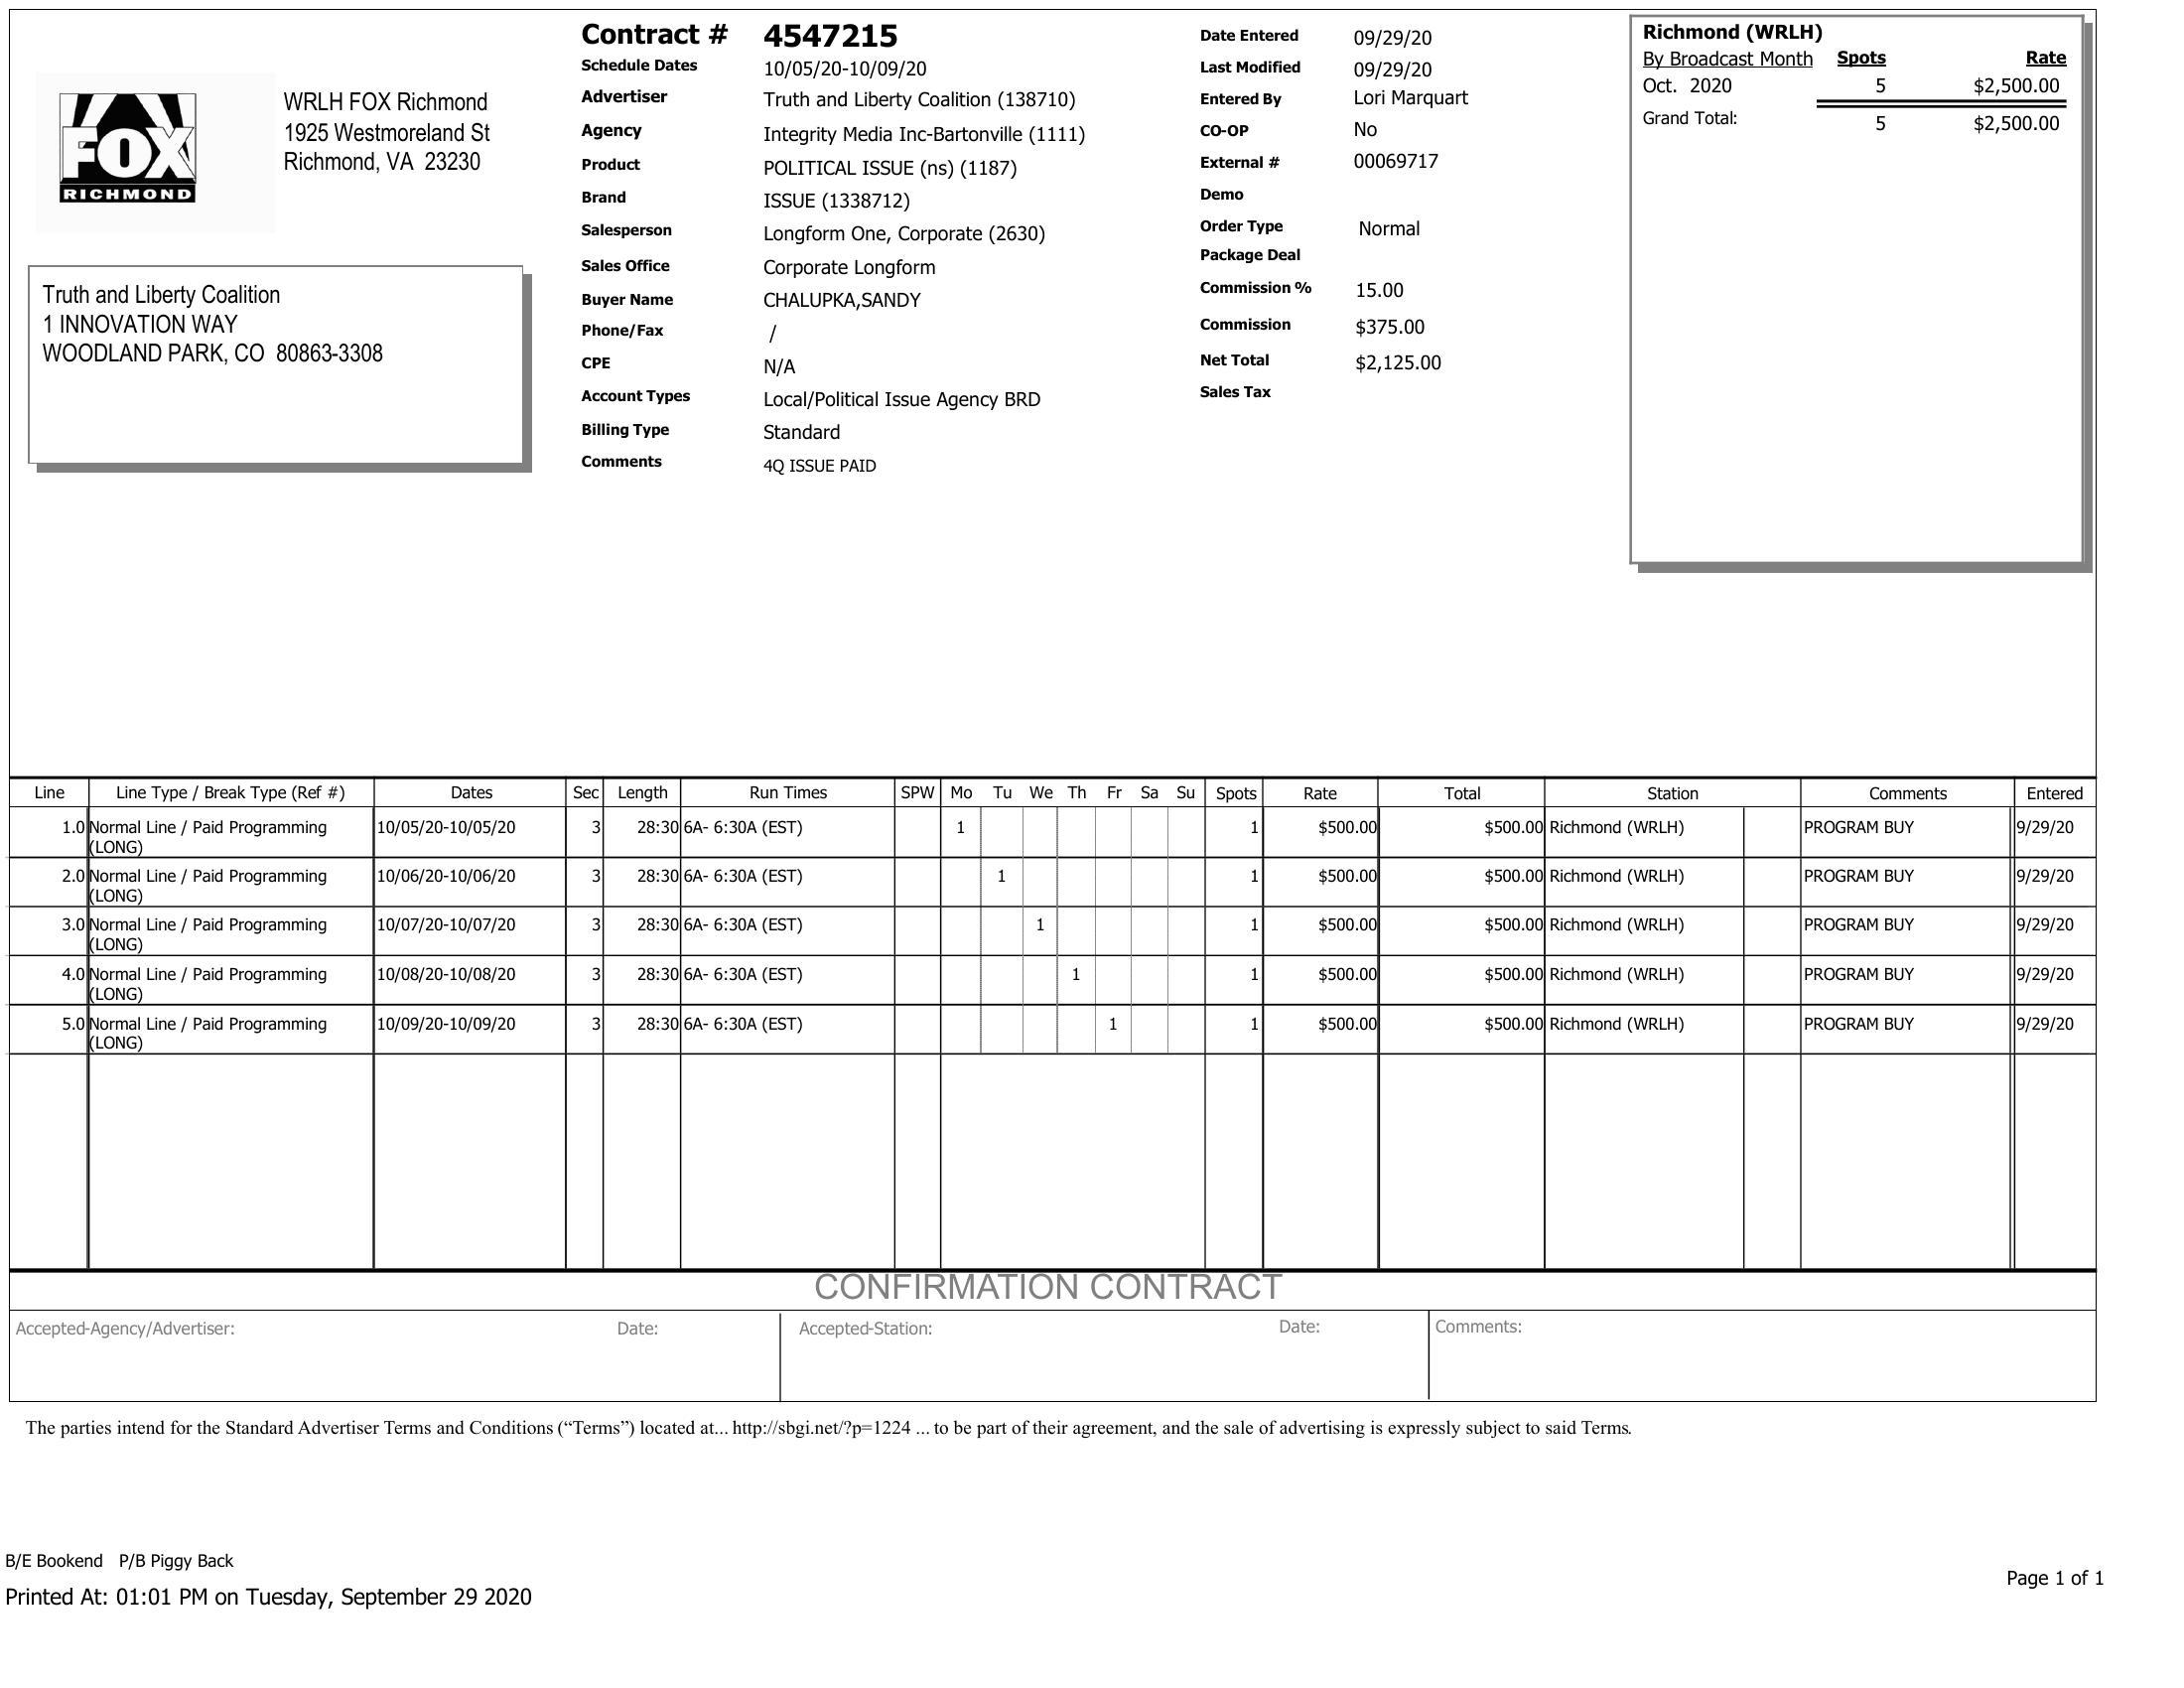

In [22]:
image_paths = (list(Path("/home/sebastian/Documents/Hauptprojekt/Daten_sorted.nosync").glob("*/*")))
random.shuffle(image_paths)
image_paths = image_paths[:100]
image = Image.open(image_paths[3]).convert("RGB")
width, height = image.size
image

### Use easy OCR

In [2]:
reader = easyocr.Reader(['en'])

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [29]:
print(torch.cuda.is_available())

False


In [30]:
image_path = image_paths[3]
ocr_result = reader.readtext(str(image_path))

In [31]:
print(ocr_result)

[([[584, 20], [738, 20], [738, 50], [584, 50]], 'Contract #', 0.9967232779589195), ([[767, 19], [909, 19], [909, 55], [767, 55]], '4547215', 0.9999929193190666), ([[1209, 27], [1311, 27], [1311, 45], [1209, 45]], 'Date Entered', 0.9738999896076551), ([[1360, 26], [1446, 26], [1446, 50], [1360, 50]], '09/29/20', 0.9216704076777166), ([[1652, 20], [1840, 20], [1840, 46], [1652, 46]], 'Richmond (WRLH)', 0.9997732680299036), ([[583, 55], [705, 55], [705, 75], [583, 75]], 'Schedule Dates', 0.9986035311916298), ([[766, 56], [938, 56], [938, 82], [766, 82]], '10/05/20-10/09/20', 0.8111785148077704), ([[1207, 57], [1313, 57], [1313, 77], [1207, 77]], 'Last Modified', 0.7391374658868475), ([[1360, 58], [1446, 58], [1446, 82], [1360, 82]], '09/29/20', 0.9216704076777166), ([[1652, 46], [1830, 46], [1830, 72], [1652, 72]], 'By_Broadcast Month', 0.8463406656353345), ([[1846, 46], [1904, 46], [1904, 70], [1846, 70]], 'Spots', 0.9999286682236361), ([[2038, 46], [2086, 46], [2086, 70], [2038, 70]], '

(-0.5, 2199.5, 1699.5, -0.5)

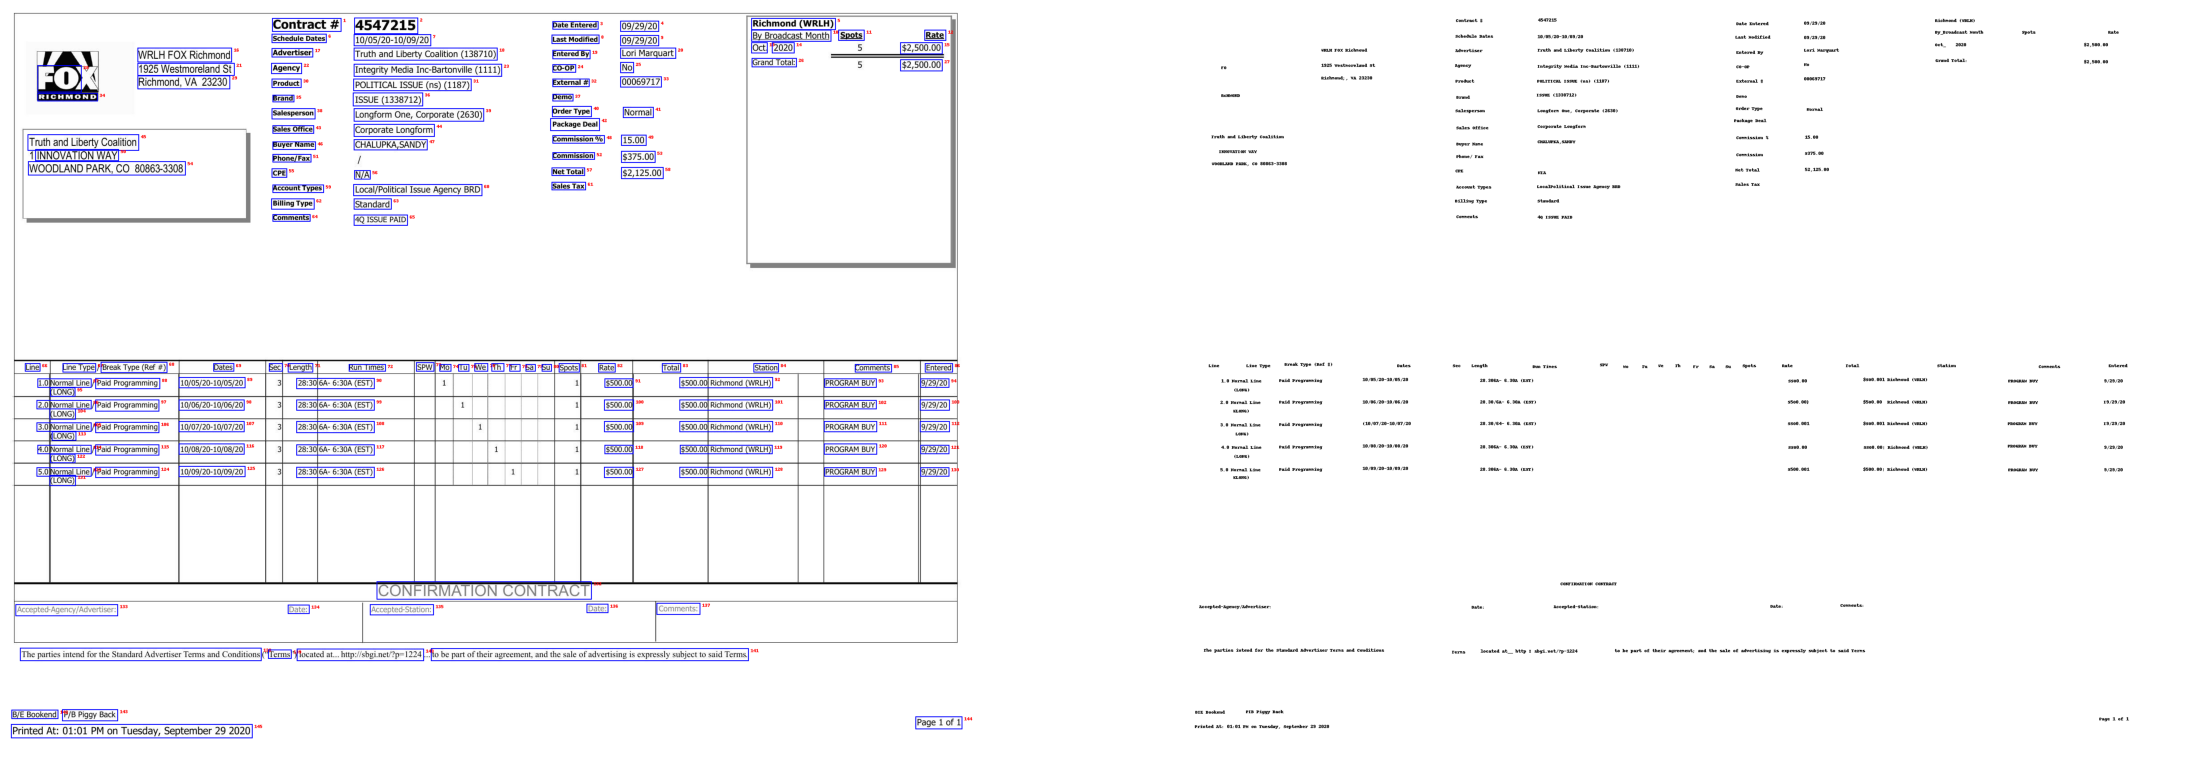

In [32]:
def create_bounding_box(bbox_data):
    xs = []
    ys = []
    for x, y in bbox_data:
        xs.append(x)
        ys.append(y)
 
    left = int(min(xs))
    top = int(min(ys))
    right = int(max(xs))
    bottom = int(max(ys))
    return [left, top, right, bottom]

font = ImageFont.load_default()
 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(28, 28))
 
left_image = Image.open(image_path).convert("RGB")
right_image = Image.new("RGB", left_image.size, (255, 255, 255))
 
left_draw = ImageDraw.Draw(left_image)
right_draw = ImageDraw.Draw(right_image)
 
for i, (bbox, word, confidence) in enumerate(ocr_result):
    box = create_bounding_box(bbox)
 
    left_draw.rectangle(box, outline="blue", width=2)
    left, top, right, bottom = box
 
    left_draw.text((right + 5, top), text=str(i + 1), fill="red", font=font)
    right_draw.text((left, top), text=word, fill="black", font=font)
 
ax1.imshow(left_image)
ax2.imshow(right_image)
ax1.axis("off")
ax2.axis("off")

In [33]:
for image_path in tqdm(image_paths):
    path_name = "/home/sebastian/Documents/Hauptprojekt/OCR/" + os.sep.join(os.path.normpath(image_path).split(os.sep)[-2:-1]) 
    filename = os.path.basename(os.path.normpath(image_path)[:-4])

    #Check if path exists
    isExist = os.path.exists(path_name)
    if not isExist:
    # Create a new directory because it does not exist
        os.makedirs(path_name)

    ocr_result = reader.readtext(str(image_path), batch_size=16)
 
    ocr_page = []
    for bbox, word, confidence in ocr_result:
        ocr_page.append({
            "word": word, "bounding_box": create_bounding_box(bbox)
        })
 
    with open(path_name + "/" + filename + ".json", "w") as outfile:
        json.dump(ocr_page, outfile)

    print("saved as: " + path_name + "/" + filename + ".json")

  1%|▍                                        | 1/100 [00:44<1:13:15, 44.40s/it]

saved as: /home/sebastian/Documents/Hauptprojekt/OCR/tax_invoice/synthetic-e51cec1535cd4964b0e6a09b-024(1).json


  2%|▊                                          | 2/100 [01:12<56:52, 34.82s/it]

saved as: /home/sebastian/Documents/Hauptprojekt/OCR/tax_invoice/synthetic-3bffa85bd9954f63b02ec8fe-221(1).json


  2%|▊                                        | 2/100 [01:26<1:10:42, 43.29s/it]


KeyboardInterrupt: 

### LayoutLMv3

In [13]:
feature_extractor = LayoutLMv3FeatureExtractor(apply_ocr=False)
tokenizer = LayoutLMv3TokenizerFast.from_pretrained(
    "microsoft/layoutlmv3-base"
)
processor = LayoutLMv3Processor(feature_extractor, tokenizer)

In [14]:
processor

LayoutLMv3Processor:
- image_processor: LayoutLMv3FeatureExtractor {
  "apply_ocr": false,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "LayoutLMv3FeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "ocr_lang": null,
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  },
  "tesseract_config": ""
}

- tokenizer: LayoutLMv3TokenizerFast(name_or_path='microsoft/layoutlmv3-base', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'sep_token': AddedToken("</s>", rstrip=Fals

Apply the processor to the sample document. LayoutLMv3 requires that each bounding box be normalized to be on a 0-1000 scale. We'll need the image width and height scale for that:

In [15]:
image_path = image_paths[0]
image = Image.open(image_path).convert("RGB")
width, height = image.size
 
width_scale = 1000 / width
height_scale = 1000 / height

In [16]:
print(image_path)

/home/sebastian/Documents/Hauptprojekt/Daten_sorted.nosync/tax_invoice/synthetic-e51cec1535cd4964b0e6a09b-024(1).jpg


In [19]:
def scale_bounding_box(box: List[int], width_scale : float = 1.0, height_scale : float = 1.0) -> List[int]:
    return [
        int(box[0] * width_scale),
        int(box[1] * height_scale),
        int(box[2] * width_scale),
        int(box[3] * height_scale)
    ]
 
f = open(("/home/sebastian/Documents/Hauptprojekt/OCR/" + os.sep.join(os.path.normpath(image_path).split(os.sep)[-2:-1]) + "/" + os.path.basename(os.path.normpath(image_path)[:-4]) + ".json"))
ocr_result = json.load(f)
 
words = []
boxes = []
for row in ocr_result:
    boxes.append(scale_bounding_box(row["bounding_box"], width_scale, height_scale))
    words.append(row["word"])
 
len(words), len(boxes)

FileNotFoundError: [Errno 2] No such file or directory: '/home/sebastian/Documents/Hauptprojekt/OCR/tax_invoice/synthetic-e51cec1535cd4964b0e6a09b-024(1).json'

In [49]:
encoding = processor(
    image,
    words,
    boxes=boxes,
    max_length=512,
    padding="max_length",
    truncation=True,
    return_tensors="pt"
)
 
print(f"""
input_ids:  {list(encoding["input_ids"].squeeze().shape)}
word boxes: {list(encoding["bbox"].squeeze().shape)}
image data: {list(encoding["pixel_values"].squeeze().shape)}
image size: {image.size}
""")


input_ids:  [512]
word boxes: [512, 4]
image data: [3, 224, 224]
image size: (1654, 2339)



In [50]:
image_data = encoding["pixel_values"][0]
transform = T.ToPILImage()
transform(image_data)

### Model

In [3]:
model = LayoutLMv3ForSequenceClassification.from_pretrained(
    "microsoft/layoutlmv3-base", num_labels=9
)

Some weights of LayoutLMv3ForSequenceClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
outputs = model(**encoding)
outputs.logits

NameError: name 'encoding' is not defined

### Finetune with Training

In [5]:
train_images, test_images = train_test_split(image_paths, test_size=.2)
DOCUMENT_CLASSES = sorted(list(map(
    lambda p: p.name,
    Path("/home/sebastian/Documents/Hauptprojekt/Daten_sorted.nosync").glob("*")
)))
if ".DS_Store" in DOCUMENT_CLASSES:
        DOCUMENT_CLASSES.remove(".DS_Store")
DOCUMENT_CLASSES


NameError: name 'image_paths' is not defined

In [6]:
class DocumentClassificationDataset(Dataset):
 
    def __init__(self, image_paths, processor):
        self.image_paths = image_paths
        self.processor = processor
 
    def __len__(self):
        return len(self.image_paths)
 
    def __getitem__(self, item):
 
        image_path = self.image_paths[item]
        json_path = image_path.with_suffix(".json")
        with json_path.open("r") as f:
            ocr_result = json.load(f)
 
            with Image.open(image_path).convert("RGB") as image:
 
                width, height = image.size
                width_scale = 1000 / width
                height_scale = 1000 / height
 
                words = []
                boxes = []
                for row in ocr_result:
                    boxes.append(scale_bounding_box(
                        row["bounding_box"],
                        width_scale,
                        height_scale
                    ))
                    words.append(row["word"])
 
                encoding = self.processor(
                    image,
                    words,
                    boxes=boxes,
                    max_length=512,
                    padding="max_length",
                    truncation=True,
                    return_tensors="pt"
                )
 
        label = DOCUMENT_CLASSES.index(image_path.parent.name)
 
        return dict(
            input_ids=encoding["input_ids"].flatten(),
            attention_mask=encoding["attention_mask"].flatten(),
            bbox=encoding["bbox"].flatten(end_dim=1),
            pixel_values=encoding["pixel_values"].flatten(end_dim=1),
            labels=torch.tensor(label, dtype=torch.long)
        )

In [7]:
train_dataset = DocumentClassificationDataset(train_images, processor)
test_dataset = DocumentClassificationDataset(test_images, processor)
 
train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=10
)
 
test_data_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=10
)

NameError: name 'train_images' is not defined

In [8]:
class ModelModule(pl.LightningModule):
    def __init__(self, n_classes:int):
        super().__init__()
        self.model = LayoutLMv3ForSequenceClassification.from_pretrained(
            "/Users/sep/Documents/HAW/Vorlesung/HP/Hauptprojekt/Models/layoutlmv3-base",
            num_labels=n_classes
        )
        self.model.config.id2label = {k: v for k, v in enumerate(DOCUMENT_CLASSES)}
        self.model.config.label2id = {v: k for k, v in enumerate(DOCUMENT_CLASSES)}
        self.train_accuracy = Accuracy(task="multiclass", num_classes=n_classes)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=n_classes)
 
    def forward(self, input_ids, attention_mask, bbox, pixel_values, labels=None):
        return self.model(
            input_ids,
            attention_mask=attention_mask,
            bbox=bbox,
            pixel_values=pixel_values,
            labels=labels
        )
 
    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        bbox = batch["bbox"]
        pixel_values = batch["pixel_values"]
        labels = batch["labels"]
        output = self(input_ids, attention_mask, bbox, pixel_values, labels)
        self.log("train_loss", output.loss)
        self.log(
            "train_acc",
            self.train_accuracy(output.logits, labels),
            on_step=True,
            on_epoch=True
        )
        return output.loss
 
    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        bbox = batch["bbox"]
        pixel_values = batch["pixel_values"]
        labels = batch["labels"]
        output = self(input_ids, attention_mask, bbox, pixel_values, labels)
        self.log("val_loss", output.loss)
        self.log(
            "val_acc",
            self.val_accuracy(output.logits, labels),
            on_step=False,
            on_epoch=True
        )
        return output.loss
 
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.00001) #1e-5
        return optimizer

In [9]:
model_module = ModelModule(len(DOCUMENT_CLASSES))

NameError: name 'DOCUMENT_CLASSES' is not defined

In [ ]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs

In [41]:
model_checkpoint = ModelCheckpoint(
    filename="{epoch}-{step}-{val_loss:.4f}", save_last=True, save_top_k=3, monitor="val_loss", mode="min"
)
 
trainer = pl.Trainer(
    accelerator="gpu",
    precision=16,
    devices=1,
    max_epochs=5,
    callbacks=[
        model_checkpoint
    ],

)

Using 16bit None Automatic Mixed Precision (AMP)
/Users/sep/miniforge3/envs/Hauptprojekt/lib/python3.10/site-packages/torch/cuda/amp/grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [42]:
trainer.fit(model_module, train_data_loader, test_data_loader)


  | Name           | Type                                | Params
-----------------------------------------------------------------------
0 | model          | LayoutLMv3ForSequenceClassification | 125 M 
1 | train_accuracy | MulticlassAccuracy                  | 0     
2 | val_accuracy   | MulticlassAccuracy                  | 0     
-----------------------------------------------------------------------
125 M     Trainable params
0         Non-trainable params
125 M     Total params
251.849   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/sep/miniforge3/envs/Hauptprojekt/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/sep/miniforge3/envs/Hauptprojekt/lib/python3.10/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'DocumentClassificationDataset' on <module '__main__' (built-in)>
/Users/sep/miniforge3/envs/Hauptprojekt/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


### Evaluation

In [ ]:
PATH = "/Users/sep/Documents/HAW/Vorlesung/HP/Hauptprojekt/Models/LayoutLMv3_finetuned.pkl"

In [57]:
trained_model = ModelModule.load_from_checkpoint(
    model_checkpoint.best_model_path,
    n_classes=len(DOCUMENT_CLASSES),
    local_files_only=True
)

torch.save(trained_model, PATH)

IsADirectoryError: [Errno 21] Is a directory: '/Users/sep/Documents/HAW/Vorlesung/HP/Hauptprojekt/Document Recognition'

In [ ]:
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

model = torch.load(PATH)
model = model.eval()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/sep/Documents/HAW/Vorlesung/HP/Hauptprojekt/Models.nosync/LayoutLMv3_finetuned.pkl'

In [ ]:
def predict_document_image(
    image_path: Path,
    model: LayoutLMv3ForSequenceClassification,
    processor: LayoutLMv3Processor):
 
    json_path = image_path.with_suffix(".json")
    with json_path.open("r") as f:
        ocr_result = json.load(f)
 
        with Image.open(image_path).convert("RGB") as image:
 
            width, height = image.size
            width_scale = 1000 / width
            height_scale = 1000 / height
 
            words = []
            boxes = []
            for row in ocr_result:
                boxes.append(
                    scale_bounding_box(
                        row["bounding_box"],
                        width_scale,
                        height_scale
                    )
                )
                words.append(row["word"])
 
            encoding = processor(
                image,
                words,
                boxes=boxes,
                max_length=512,
                padding="max_length",
                truncation=True,
                return_tensors="pt"
            )
 
    with torch.inference_mode():
        output = model(
            input_ids=encoding["input_ids"].to(DEVICE),
            attention_mask=encoding["attention_mask"].to(DEVICE),
            bbox=encoding["bbox"].to(DEVICE),
            pixel_values=encoding["pixel_values"].to(DEVICE)
        )
 
    predicted_class = output.logits.argmax()
    return model.config.id2label[predicted_class.item()]

In [ ]:
labels = []
predictions = []
for image_path in tqdm(test_images):
    labels.append(image_path.parent.name)
    predictions.append(
        predict_document_image(image_path, model, processor)
    )

In [ ]:
cm = confusion_matrix(labels, predictions, labels=DOCUMENT_CLASSES)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=DOCUMENT_CLASSES
)
 
cm_display.plot()
cm_display.ax_.set_xticklabels(DOCUMENT_CLASSES, rotation=45)
cm_display.figure_.set_size_inches(16, 8)
 
plt.show()